In [23]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import tensorflow.keras.backend as K


In [24]:
# Load your metadata CSV
meta = pd.read_csv("meta_train.csv")

# Clean image_id
meta['image_id'] = meta['image_id'].str.replace('.jpg', '', regex=False).str.lower()

# Encode target
label_encoder = LabelEncoder()
meta['variety_encoded'] = label_encoder.fit_transform(meta['variety'])

# Save for decoding
variety_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Variety label map:", variety_map)

# Compute class weights for imbalance handling
y_data = np.array(meta['variety_encoded'])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_data), y=y_data)
class_weights_dict = dict(enumerate(class_weights))



Variety label map: {'ADT45': np.int64(0), 'AndraPonni': np.int64(1), 'AtchayaPonni': np.int64(2), 'IR20': np.int64(3), 'KarnatakaPonni': np.int64(4), 'Onthanel': np.int64(5), 'Ponni': np.int64(6), 'RR': np.int64(7), 'Surya': np.int64(8), 'Zonal': np.int64(9)}
TensorFlow version: 2.19.0
Num GPUs Available: 0


In [25]:
# Full path to image folder
IMAGE_ROOT = r"C:\Users\bazen\PyCharmMiscProject\.venv\train_images"

# Index all image paths from subfolders
image_index = {}
for path in glob.glob(os.path.join(IMAGE_ROOT, "*", "*.jpg")):
    image_id = os.path.basename(path).split('.')[0].lower()
    image_index[image_id] = path


In [26]:

IMG_SIZE = 128

def load_and_process_image(img_id):
    path = image_index.get(img_id)
    if not path:
        raise FileNotFoundError(f"{img_id} not found in index!")
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    return img_to_array(img) / 255.0

# Load all images into arrays
x_data = np.array([load_and_process_image(iid) for iid in meta['image_id']])
y_data = np.array(meta['variety_encoded'])

print("Image data shape:", x_data.shape)
print("Labels shape:", y_data.shape)


Image data shape: (10407, 128, 128, 3)
Labels shape: (10407,)


In [27]:
# Set up 5-Fold Cross-Validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []

# Image generator with horizontal flip only
datagen = ImageDataGenerator(horizontal_flip=True)

for fold, (train_idx, val_idx) in enumerate(skf.split(x_data, y_data)):
    print(f"\n📂 Fold {fold+1}/{k}")

    # Split data for this fold
    x_train, x_val = x_data[train_idx], x_data[val_idx]
    y_train, y_val = y_data[train_idx], y_data[val_idx]

    # Build model for each fold
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(variety_map), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train using augmented data
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_val, y_val),
        epochs=30,
        verbose=1
    )

    # Evaluate
    val_loss, val_acc = model.evaluate(x_val, y_val)
    accuracies.append(val_acc)
    print(f"✅ Fold {fold+1} validation accuracy: {val_acc:.4f}")



📂 Fold 1/5


C:\Users\bazen\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\bazen\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.6510 - loss: 1.4628 - val_accuracy: 0.7113 - val_loss: 0.9509
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.7471 - loss: 0.7923 - val_accuracy: 0.8108 - val_loss: 0.5847
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.8439 - loss: 0.4770 - val_accuracy: 0.8405 - val_loss: 0.4684
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9133 - loss: 0.2825 - val_accuracy: 0.8775 - val_loss: 0.3981
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9432 - loss: 0.1805 - val_accuracy: 0.8516 - val_loss: 0.4336
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9615 - loss: 0.1281 - val_accuracy: 0.8804 - val_loss: 0.4183
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9753 - loss: 0.0890 - val_accuracy: 0.8900 - val_loss: 0.4183
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9780 - loss: 0.0675 - 

In [28]:
# # Build CNN Model
# model = models.Sequential([
#     layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#     layers.MaxPooling2D(2,2),
#
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D(2,2),
#
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(len(variety_map), activation='softmax')
# ])
#
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
#
# model.summary()


In [29]:
# # Train Model
# history = model.fit(
#     x_train, y_train,
#     validation_data=(x_val, y_val),
#     epochs=30,
#     batch_size=32
# )



📈 Cross-Validation Results:
Average Accuracy: 0.9076
Standard Deviation: 0.0100


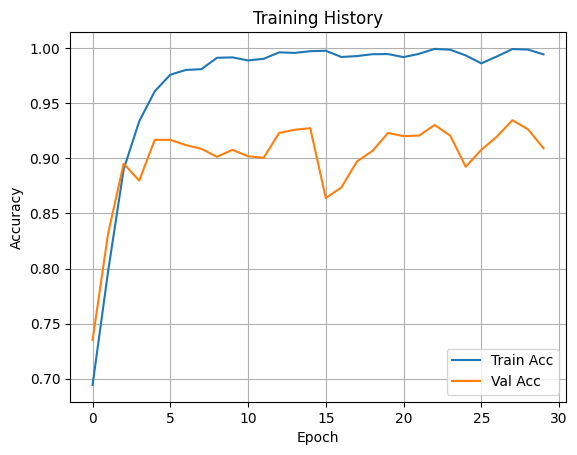

In [30]:
# val_loss, val_acc = model.evaluate(x_val, y_val)
# print(f"Validation accuracy: {val_acc:.4f}")
print("\n📈 Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


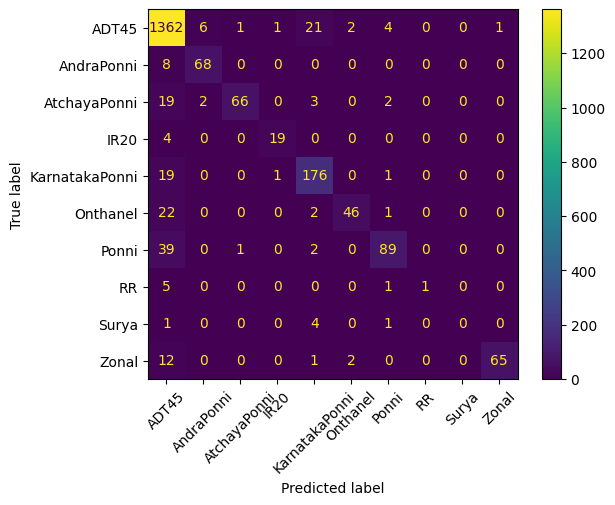

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes for validation set
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))


                precision    recall  f1-score   support

         ADT45       0.91      0.97      0.94      1398
    AndraPonni       0.89      0.89      0.89        76
  AtchayaPonni       0.97      0.72      0.82        92
          IR20       0.90      0.83      0.86        23
KarnatakaPonni       0.84      0.89      0.87       197
      Onthanel       0.92      0.65      0.76        71
         Ponni       0.90      0.68      0.77       131
            RR       1.00      0.14      0.25         7
         Surya       0.00      0.00      0.00         6
         Zonal       0.98      0.81      0.89        80

      accuracy                           0.91      2081
     macro avg       0.83      0.66      0.71      2081
  weighted avg       0.91      0.91      0.90      2081



C:\Users\bazen\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bazen\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bazen\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu